In [1]:
# define the path of the data and project
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

In [2]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_750=xr.open_dataset(f"{data_path}/ds_cleaned_750.nc")
# convert the profile data to string
ds_cleaned_750['profiler']=ds_cleaned_750['profiler'].astype(str)

In [9]:
np.min(ds_cleaned_750['lat'].values)

71.2433

In [3]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_250=xr.open_dataset(f"{data_path}/ds_cleaned_250.nc")
# convert the profile data to string
ds_cleaned_250['profiler']=ds_cleaned_250['profiler'].astype(str)
# exclude the data with lat<60
ds_cleaned_250=ds_cleaned_250.where(ds_cleaned_250['lat']>60,drop=True)

In [10]:
np.min(ds_cleaned_250['lat'].values)

42.9441

In [4]:
from pyxpcm.models import pcm
import numpy as np

def GMM(ds_train,ds_fit,K):  
    if np.max(ds_train.pressure) >=0:
        print('Warning, the pressure is not negative!!!')
    pstart=np.max(ds_train.pressure)
    pend=np.min(ds_train.pressure)
    z = np.arange(pstart,pend,-10.)

    pcm_features = {'temperature': z, 'salinity':z}
    m = pcm(K=K, features=pcm_features)
    
    features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}

    m.fit(ds_train,features=features_in_ds,dim='pressure')
    ds_fit=m.predict(ds_fit,features=features_in_ds,dim='pressure',inplace=True)
    return ds_fit,m

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_labels(ds, m,show_title=False):
    proj = ccrs.NorthPolarStereo()
    subplot_kw={'projection': proj}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

    kmap = m.plot.cmap()
    sc = ax.scatter(ds['lon'], ds['lat'], s=3, c=ds['PCM_LABELS'], cmap=kmap, transform=ccrs.PlateCarree(), vmin=0, vmax=m.K)
    cl = m.plot.colorbar(ax=ax)

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    if show_title:
        ax.set_title(f'lat_step={ds.lat_step.values}, lon_step={ds.lon_step.values}, quantile4T={ds.quantile4T.values},nprof_of_train={ds.nprof_of_train.values}')

    plt.show()


def plot_mean_profile(ds_fit, m):
    # Calculate the quantile and plot it
    for vname in ['temperature', 'salinity']:
        ds_fit = ds_fit.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

    ds_group = ds_fit.groupby('PCM_LABELS')
    num_classes = len(ds_group)
    num_rows = (num_classes + 3) // 4  # Calculate the number of rows
    num_cols = min(num_classes, 4)  # Set a maximum of four subplots in a row

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows), dpi=300)

    for i, ax in enumerate(axs.flat):
        if i < num_classes:
            qua5 = ds_group[0]['temperature_Q'][i][0].values
            qua50 = ds_group[0]['temperature_Q'][i][1].values
            qua95 = ds_group[0]['temperature_Q'][i][2].values
            ax.plot(qua5, ds_group[0]['pressure'].values, c='b', label=0.05)
            ax.plot(qua50, ds_group[0]['pressure'].values, c='r', label=0.50)
            ax.plot(qua95, ds_group[0]['pressure'].values, c='g', label=0.95)
            ax.grid(True)
            ax.legend()
            ax.set_title(f'Class {i}')
            if i==0:
                ax.set_ylabel('Pressure')
                ax.set_xlabel('Temperature')

    plt.subplots_adjust(wspace=0.3, hspace=0.25)
    plt.show()



# def plot_mean_profile(ds_fit,m):
#     # Calculate the quantile and plot it
#     for vname in ['temperature', 'salinity']:
#         ds_fit = ds_fit.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)    

#     ds_group = ds_fit.groupby('PCM_LABELS')
#     ncols=len(ds_group)
#     fig, axs = plt.subplots(1, ncols, figsize=(12, 4*ncols),dpi=300)

#     for i in range(ncols):
#         qua5=ds_group[0]['temperature_Q'][i][0].values
#         qua50=ds_group[0]['temperature_Q'][i][1].values
#         qua95=ds_group[0]['temperature_Q'][i][2].values
#         ax=axs[i]
#         ax.plot(qua5,ds_group[0]['pressure'].values,c='b',label=0.05)
#         ax.plot(qua50,ds_group[0]['pressure'].values,c='r',label=0.50)
#         ax.plot(qua95,ds_group[0]['pressure'].values,c='g',label=0.95)
#         ax.grid(True)
#         ax.legend()
#         ax.set_title(f'Class {i}')
#         ax.set_ylabel('Pressure')
#         ax.set_xlabel('Temperature')

#     plt.subplots_adjust(wspace=0.3, hspace=0.25)
#     plt.show()


In [6]:
import prepare_training_data_functions as ptd

ds_train_750_latlonT_5_30_95=ptd.prepare_training_data(5,30,0.95,ds_cleaned_750)
ds_fit_750_latlonT_5_30_95,m_750_latlonT_5_30_95=GMM(ds_train_750_latlonT_5_30_95,ds_cleaned_750.copy(),8)
ds_fit_750_latlonT_5_30_95=ptd.add_info(ds_train_750_latlonT_5_30_95,ds_fit_750_latlonT_5_30_95)


Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1569
threshold=2135, training dataset size=18828


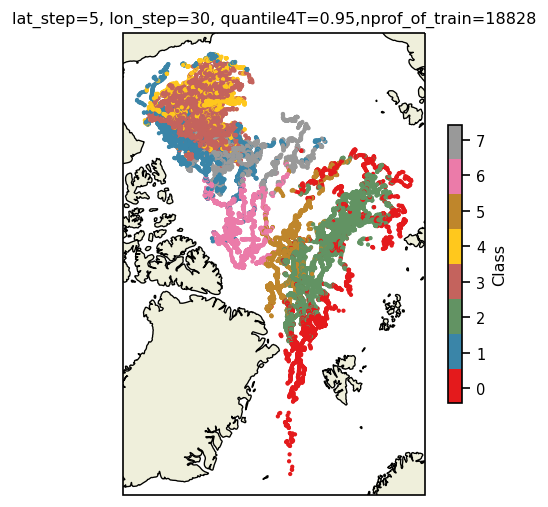

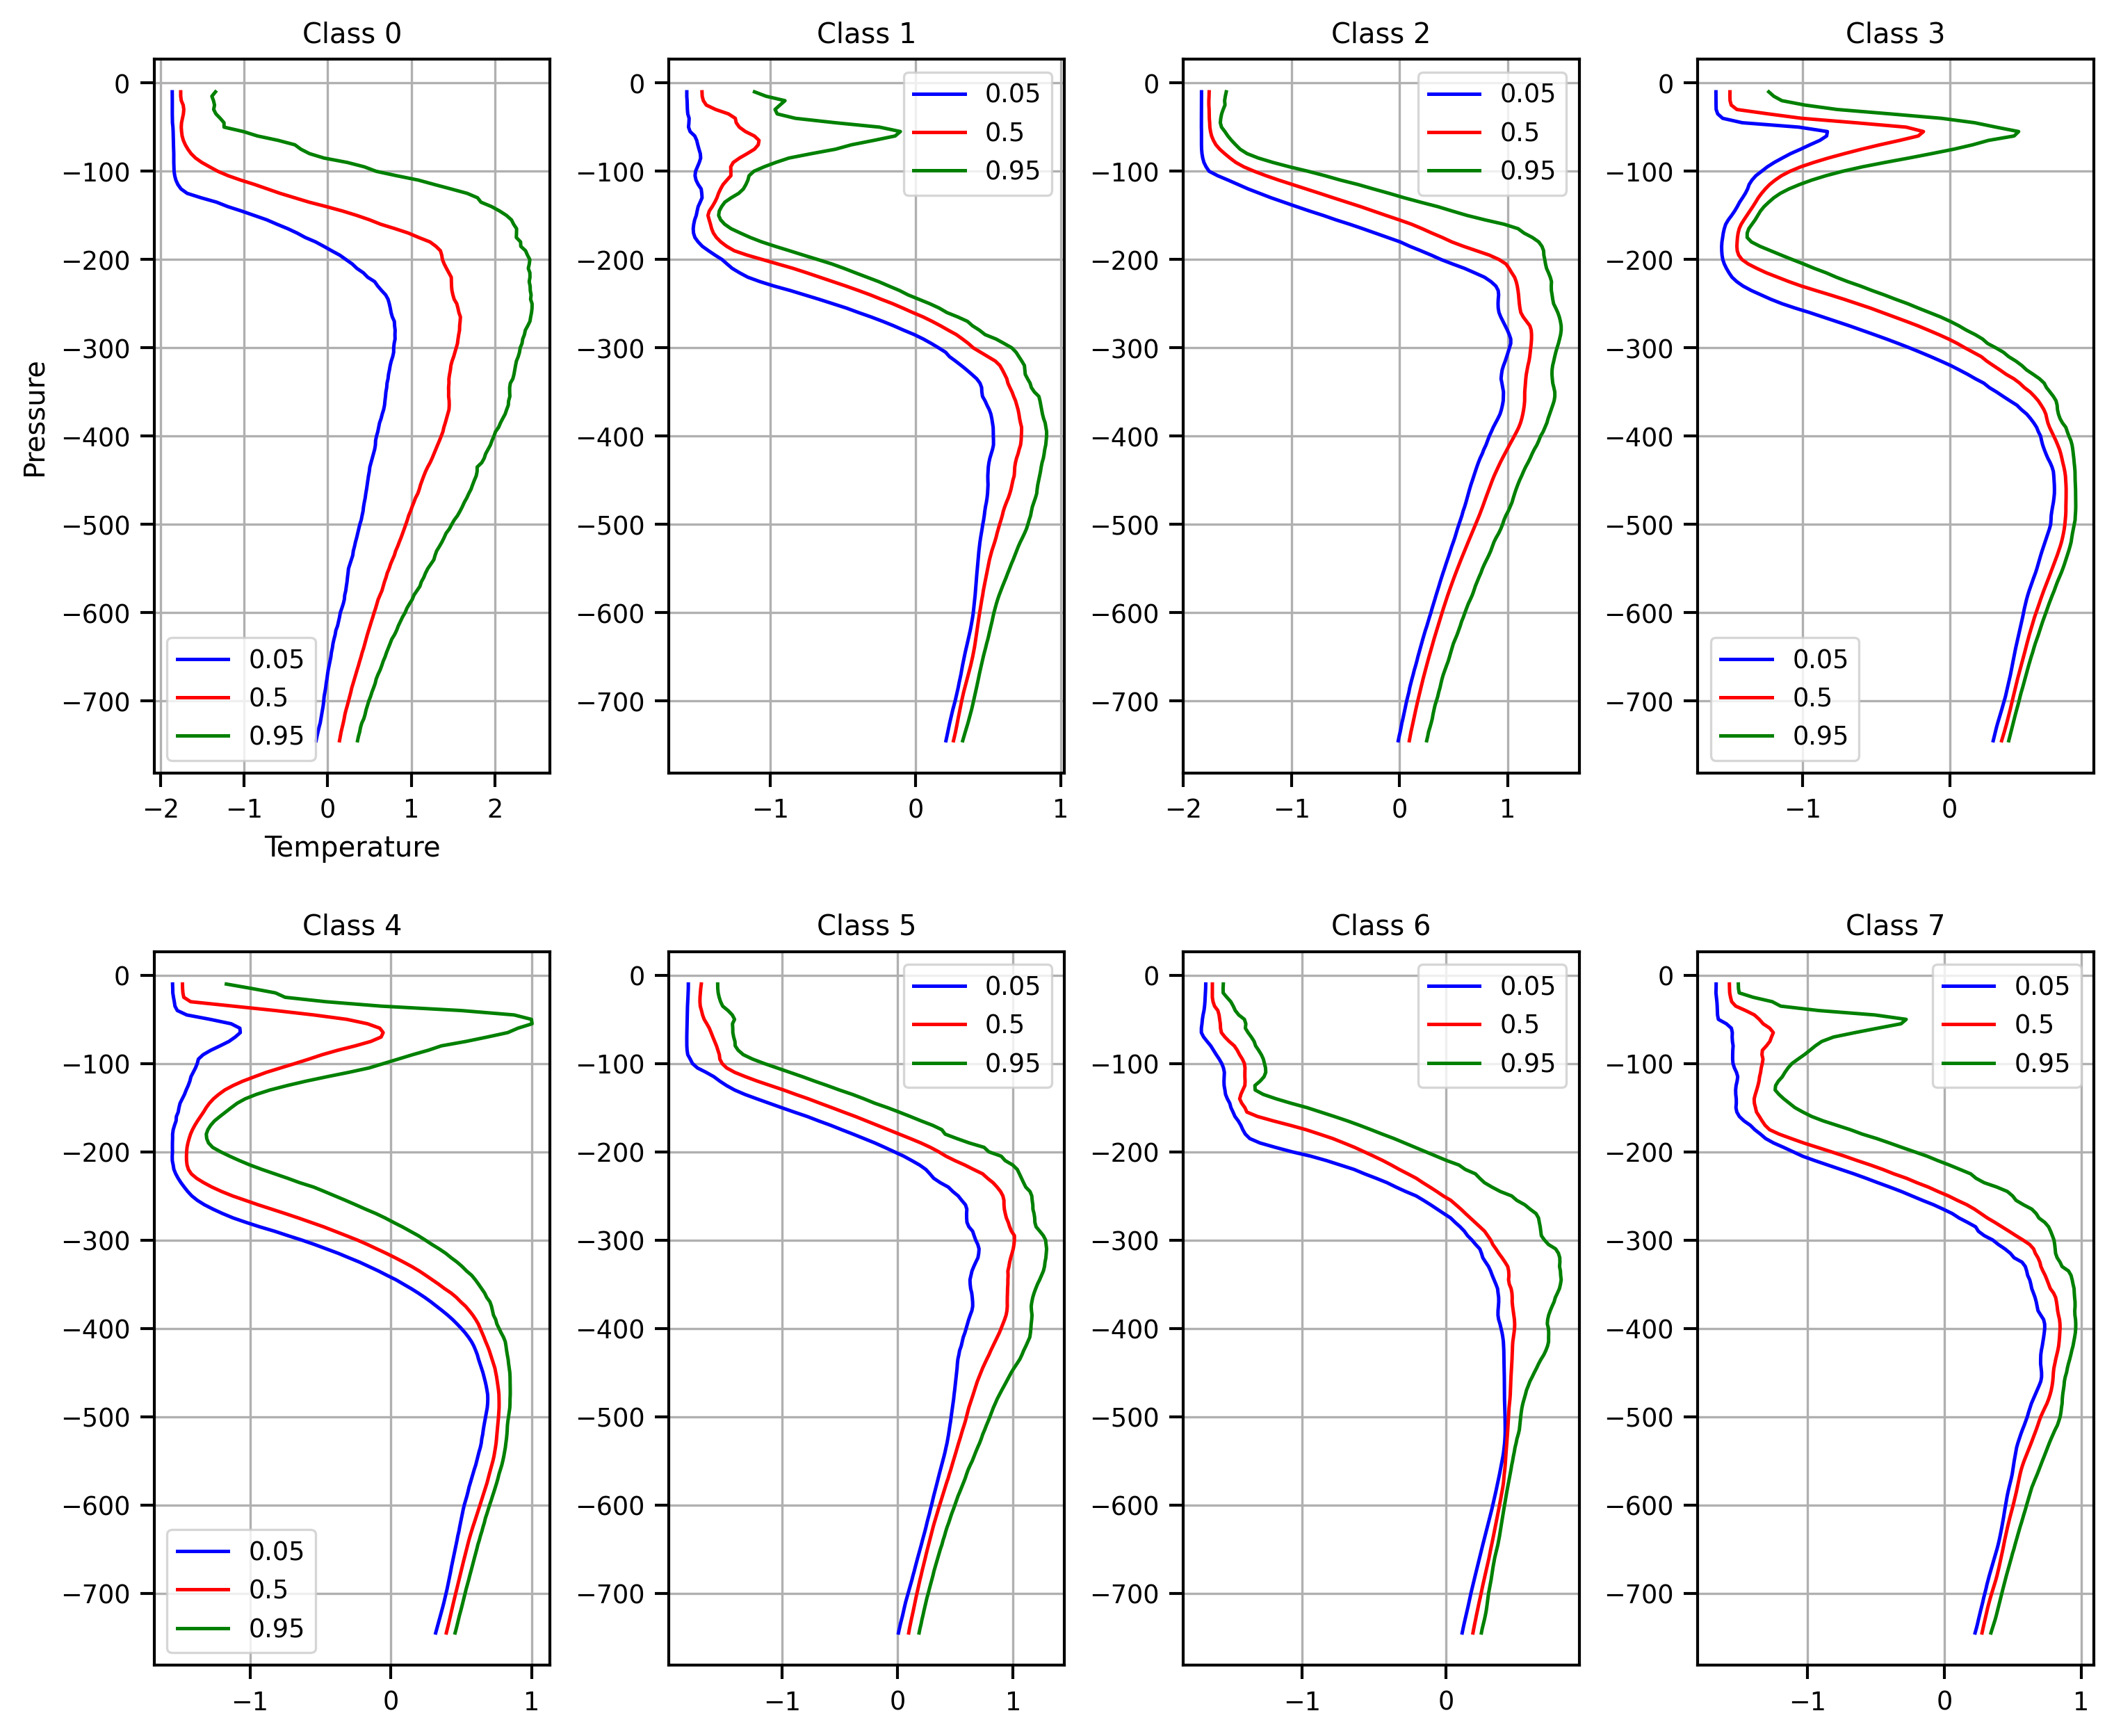

In [7]:
plot_labels(ds_fit_750_latlonT_5_30_95,m_750_latlonT_5_30_95,show_title=True)
plot_mean_profile(ds_fit_750_latlonT_5_30_95,m_750_latlonT_5_30_95)

In [10]:
import prepare_training_data_functions as ptd

ds_train_750_latlonT_2_10_95=ptd.prepare_training_data(2,10,0.95,ds_cleaned_750)
ds_fit_750_latlonT_2_10_95,m_750_latlonT_2_10_95=GMM(ds_train_750_latlonT_2_10_95,ds_cleaned_750.copy(),8)
ds_fit_750_latlonT_2_10_95=ptd.add_info(ds_train_750_latlonT_2_10_95,ds_fit_750_latlonT_2_10_95)

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1337
threshold=379, training dataset size=16044


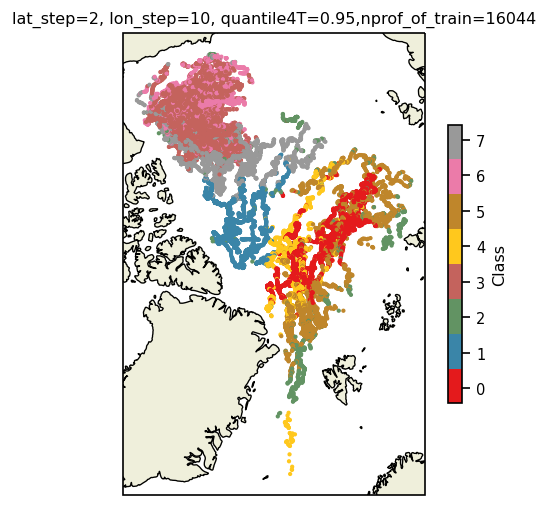

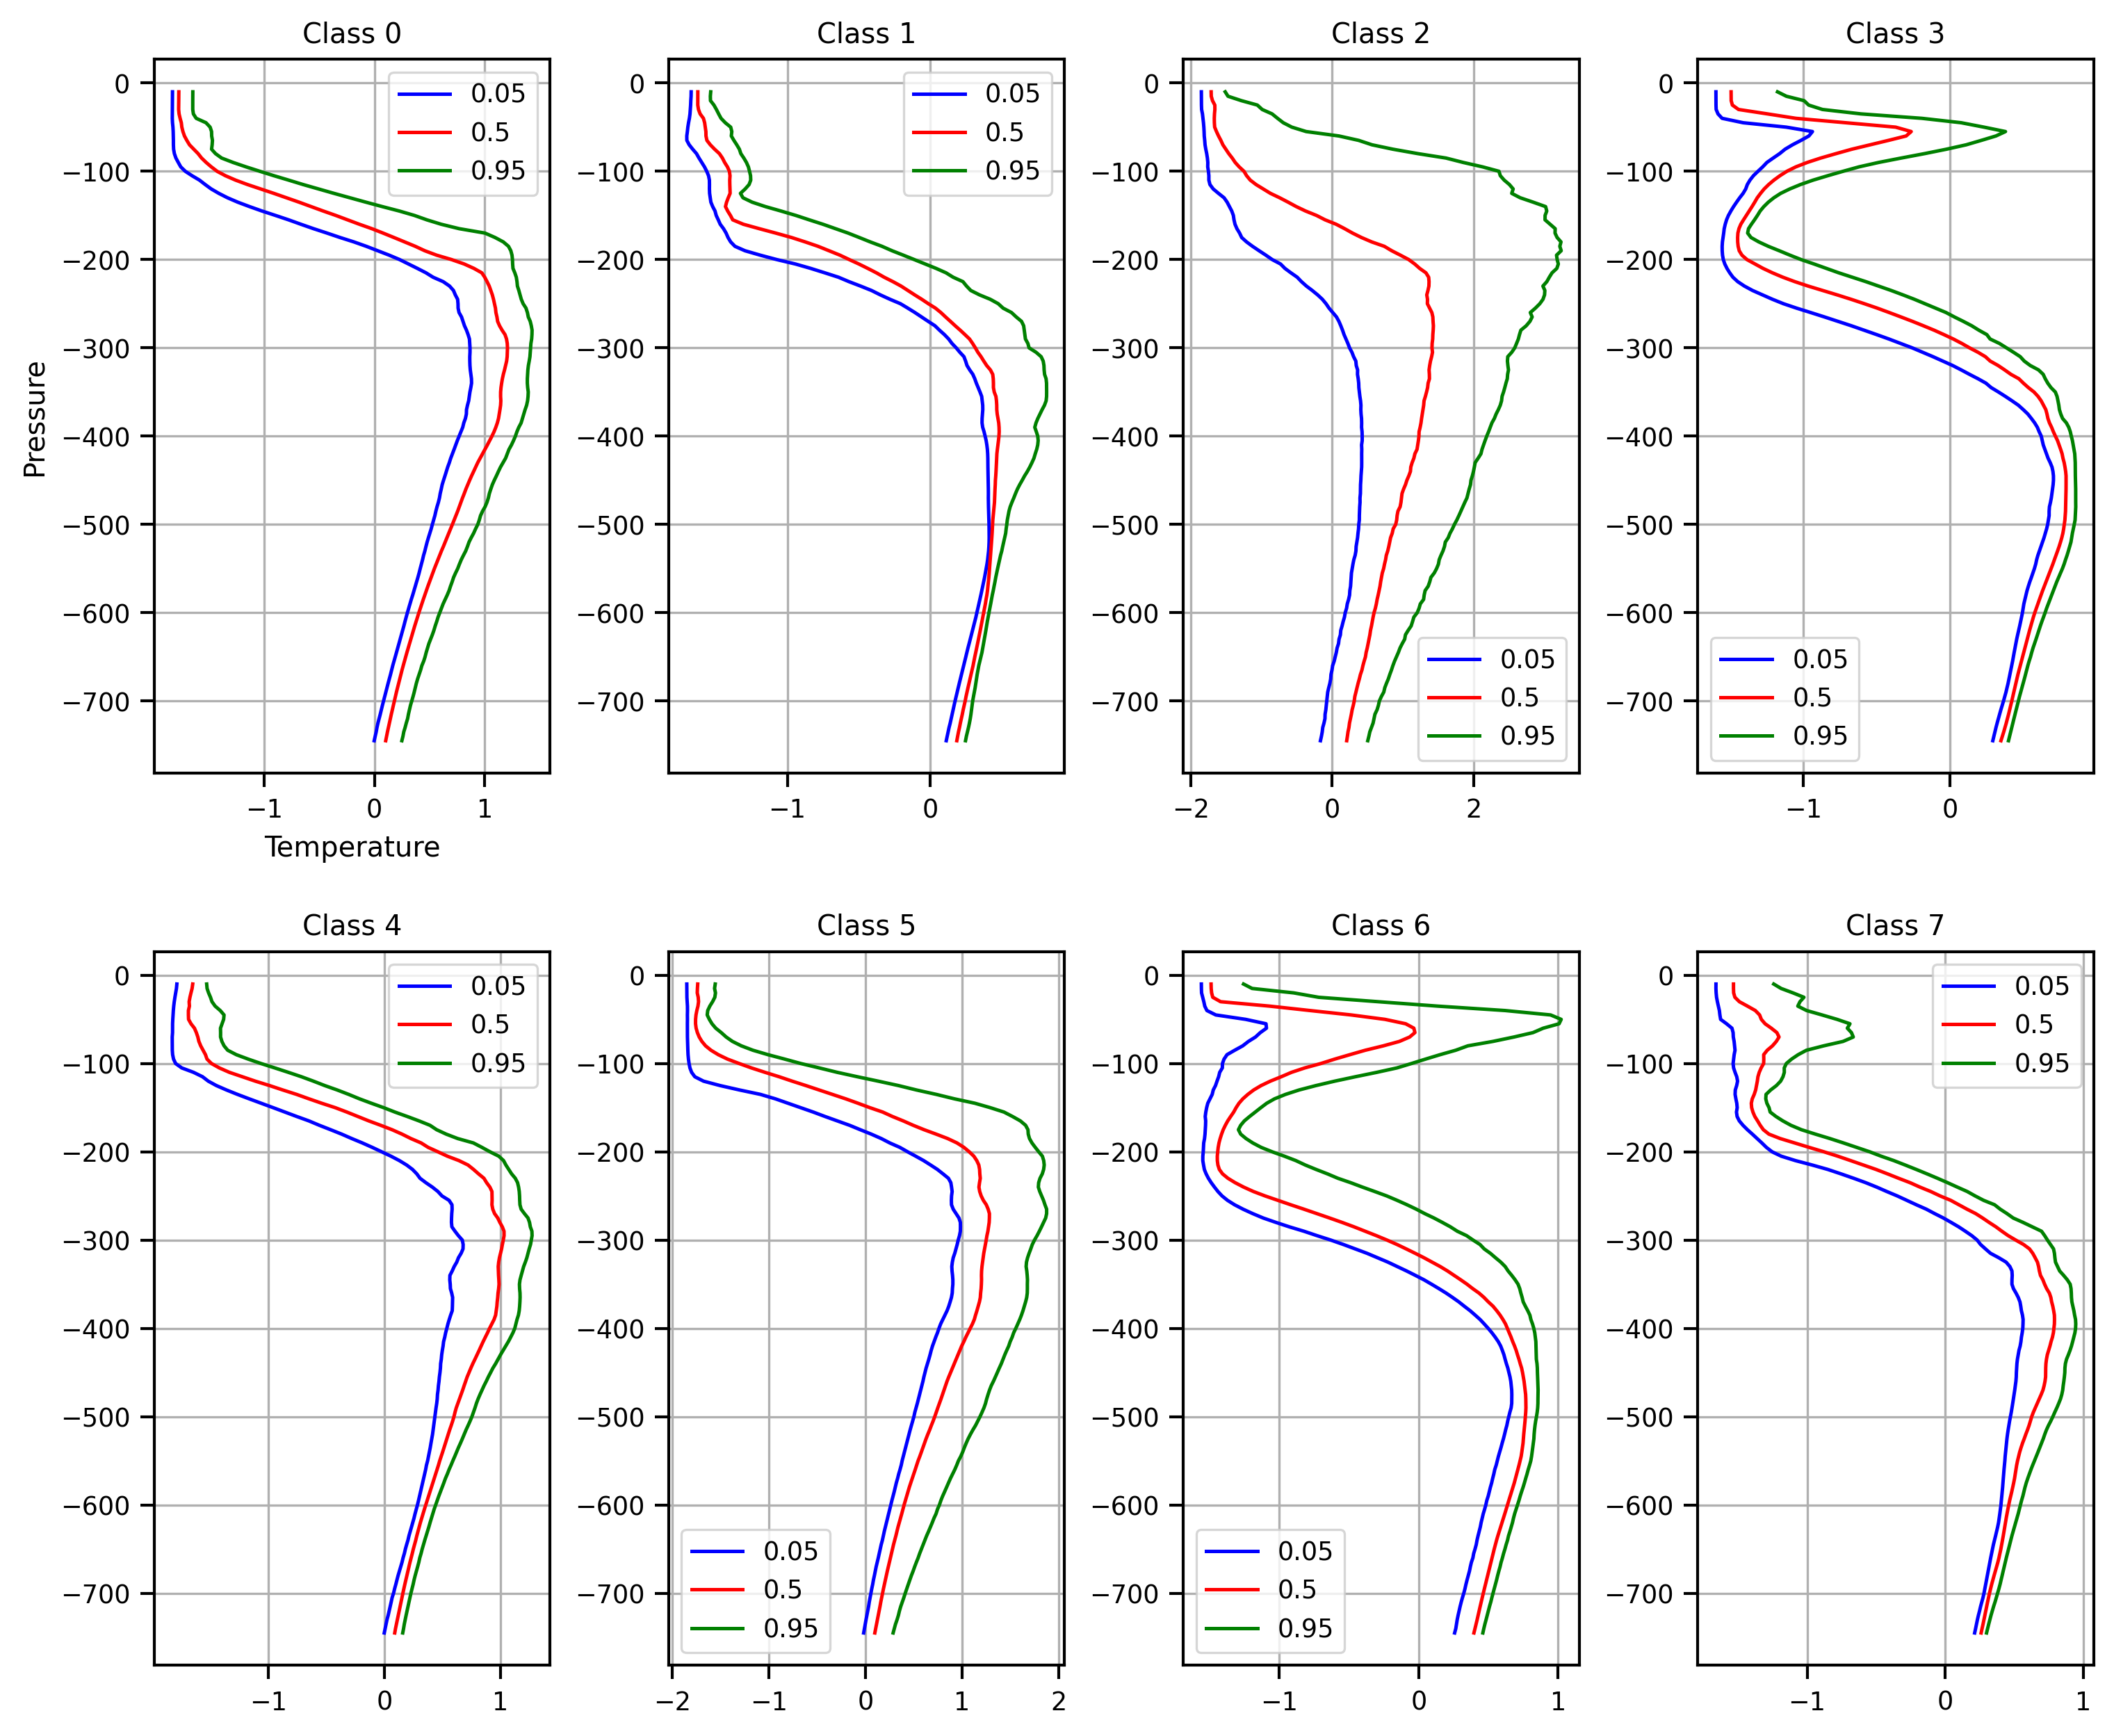

In [11]:
plot_labels(ds_fit_750_latlonT_2_10_95,m_750_latlonT_2_10_95,show_title=True)
plot_mean_profile(ds_fit_750_latlonT_2_10_95,m_750_latlonT_2_10_95)

In [8]:
import prepare_training_data_functions as ptd

ds_train_250_latlonT_5_30_95=ptd.prepare_training_data(5,30,0.95,ds_cleaned_250)
ds_fit_250_latlonT_5_30_95,m_205_latlonT_5_30_95=GMM(ds_train_250_latlonT_5_30_95,ds_cleaned_250.copy(),8)
ds_fit_250_latlonT_5_30_95=ptd.add_info(ds_train_250_latlonT_5_30_95,ds_fit_250_latlonT_5_30_95)


Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 2289
threshold=3870, training dataset size=27468


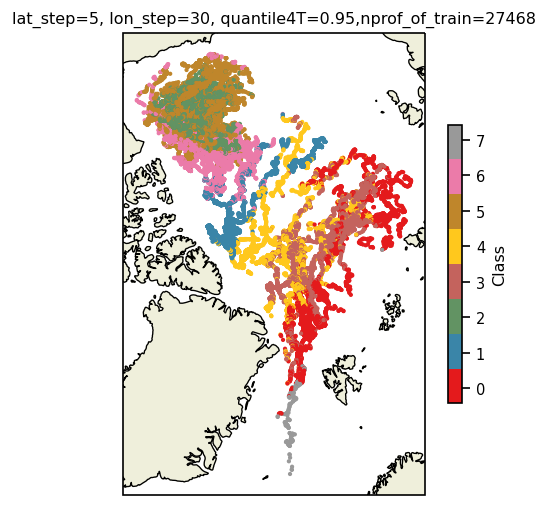

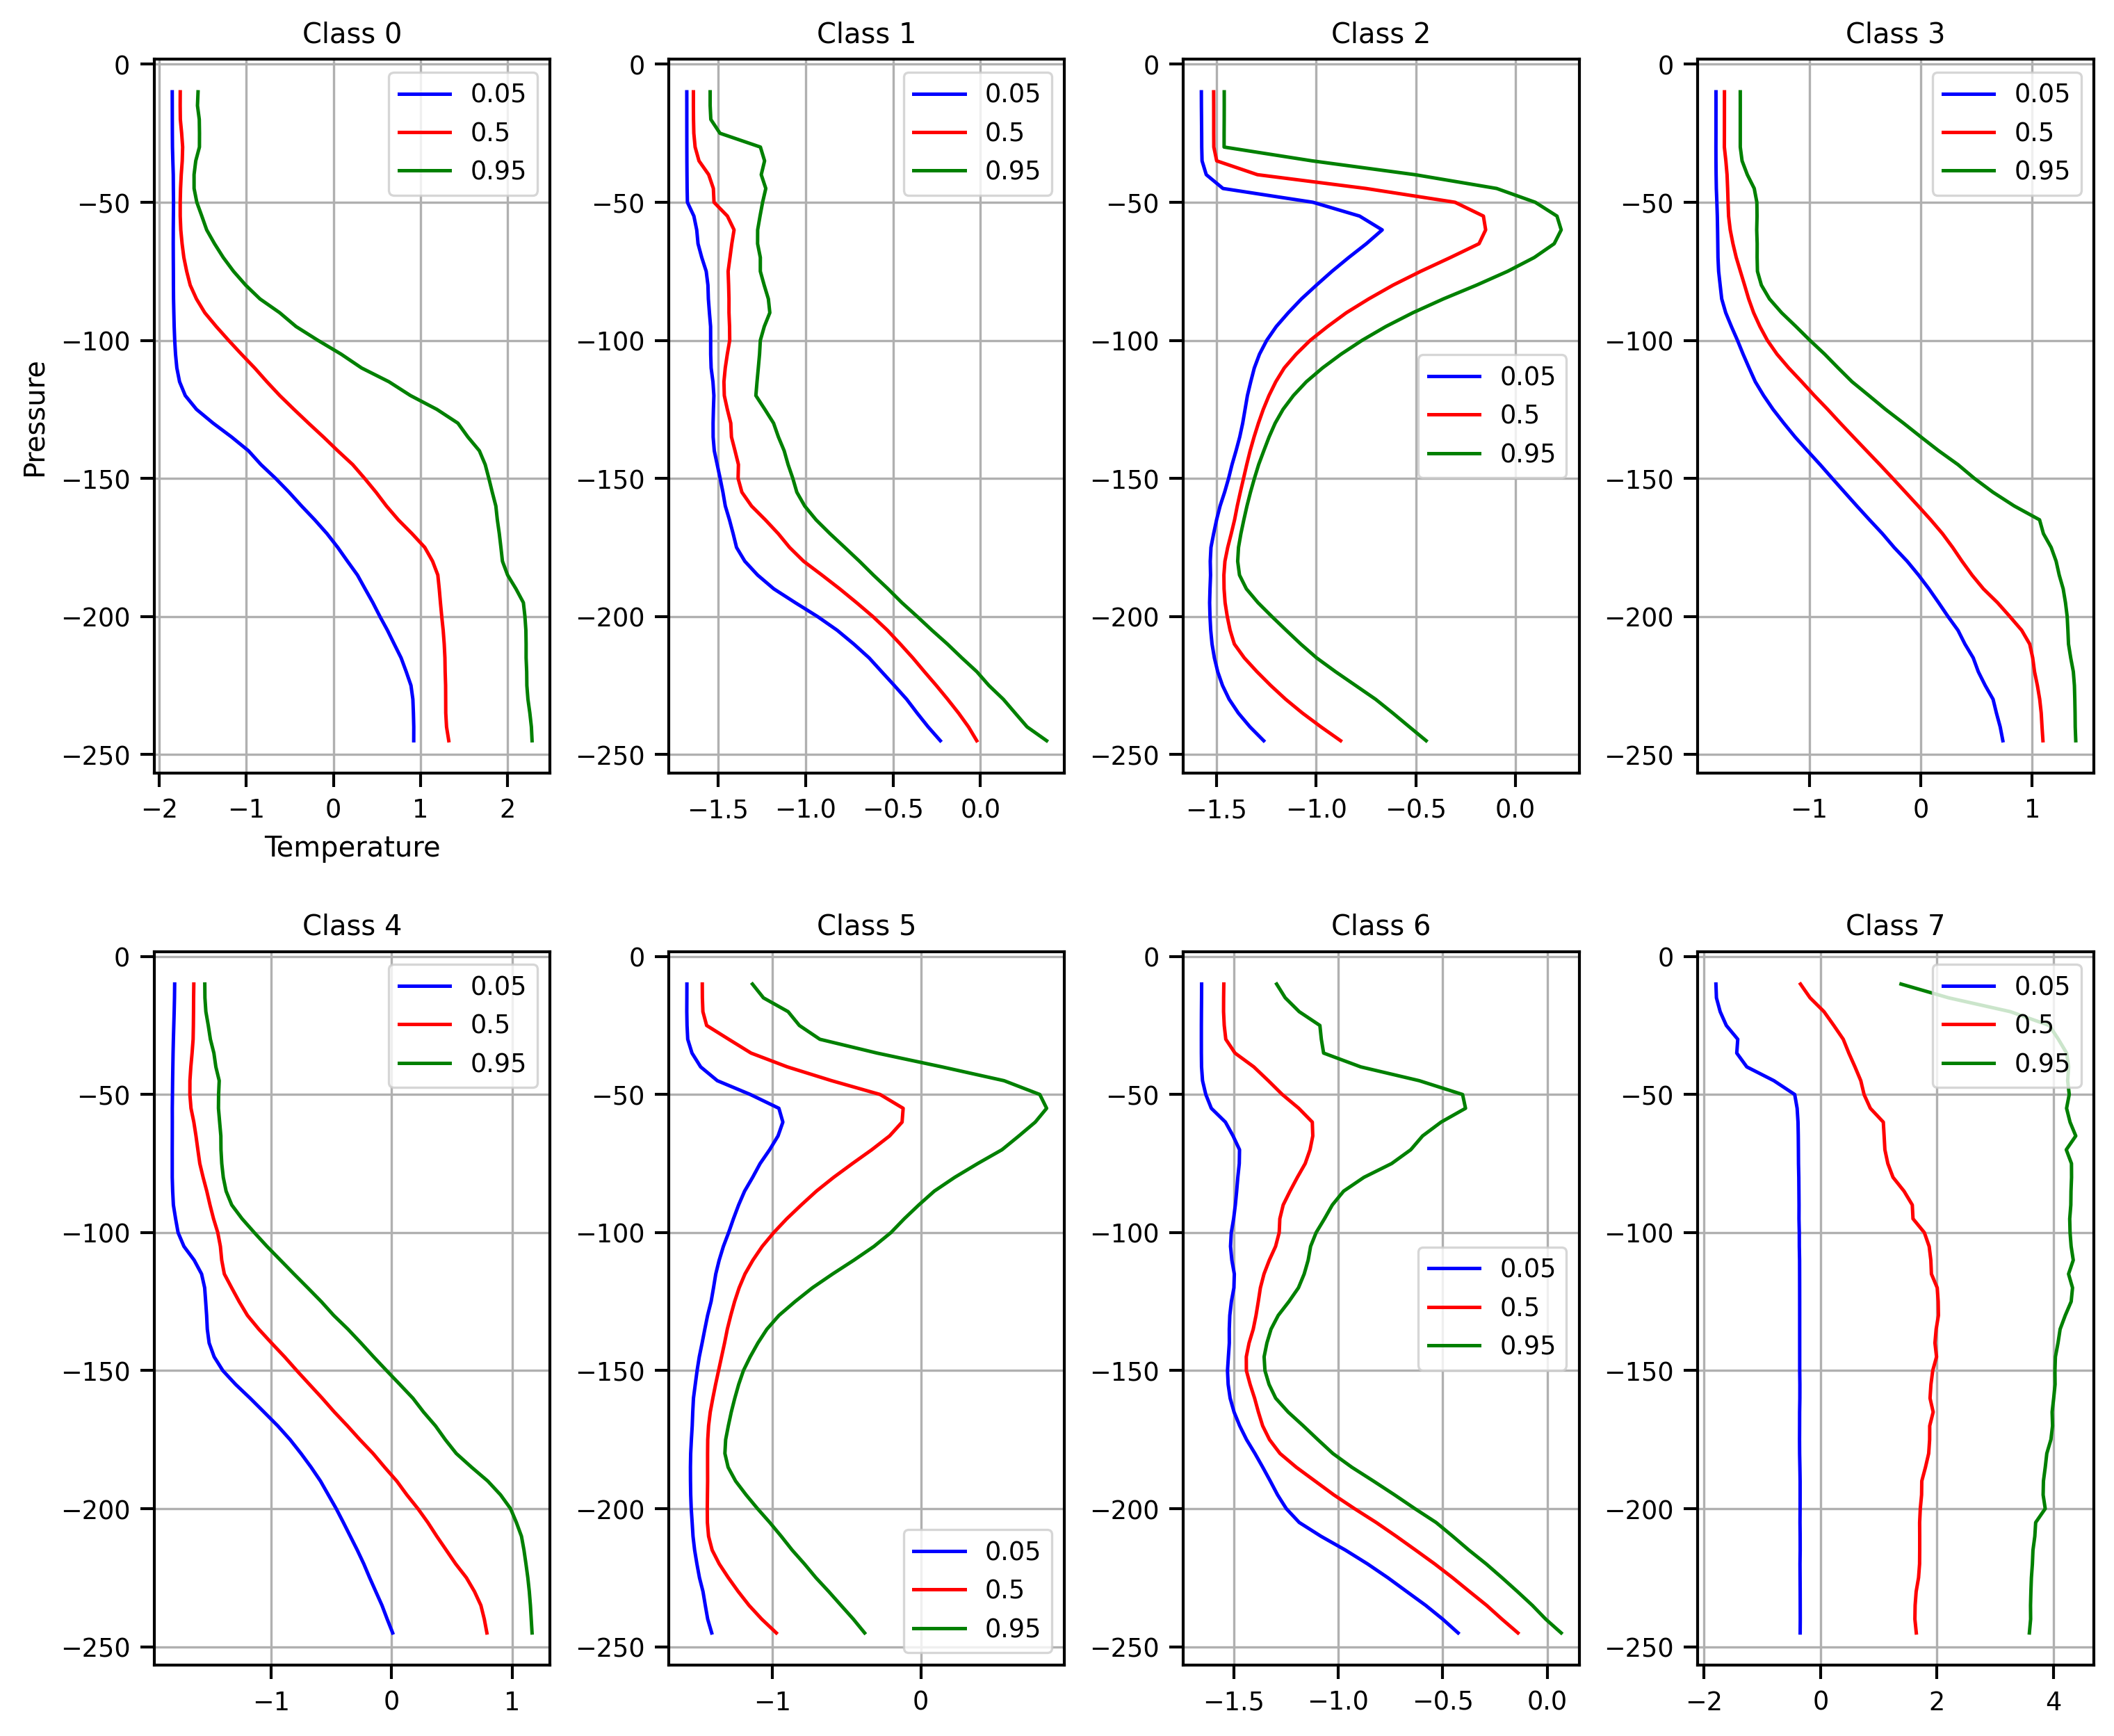

In [9]:
plot_labels(ds_fit_250_latlonT_5_30_95,m_205_latlonT_5_30_95,show_title=True)
plot_mean_profile(ds_fit_250_latlonT_5_30_95,m_205_latlonT_5_30_95)